In [2]:
import pandas as pd
import numpy as np
import os

print("Loading data and predictions...")

# Load frequency data
df = pd.read_csv("../data/freq_data.csv")
df = df[(df["Exposure"] > 0) & (df["Exposure"] <= 1)].copy()

# Load CatBoost predictions (from Notebook 3)
pred_path = "../outputs/catboost_predictions.csv"
if not os.path.exists(pred_path):
    raise FileNotFoundError(
        f"{pred_path} not found. Go back to Notebook 3 and run the cell that saves catboost_predictions.csv."
    )

pred_df = pd.read_csv(pred_path)
df["y_true"] = df["ClaimNb"].astype(float)
df["y_pred"] = pred_df["pred"].astype(float)

print("✅ Data and predictions loaded.")
print(df[["ClaimNb", "y_pred"]].head())
print(f"Total rows: {len(df):,}")


Loading data and predictions...
✅ Data and predictions loaded.
   ClaimNb        y_pred
0        1  9.964554e-01
1        1  9.999996e-07
2        1  9.999996e-07
3        1  9.999996e-07
4        1  9.999996e-07
Total rows: 676,789


In [3]:
print("=" * 70)
print("DEFINING FAIRNESS GROUPS")
print("=" * 70)

# Age bands
df["DrivAge_band"] = pd.cut(
    df["DrivAge"],
    bins=[17, 25, 40, 60, 100],
    labels=["18-25", "26-40", "41-60", "61+"]
)

# Urban vs rural using median density
median_density = df["Density"].median()
df["Urbanicity"] = np.where(df["Density"] >= median_density, "Urban", "Rural")

print("Age bands:", df["DrivAge_band"].unique())
print("Urbanicity:", df["Urbanicity"].unique())


DEFINING FAIRNESS GROUPS
Age bands: ['41-60', '26-40', '18-25', '61+']
Categories (4, object): ['18-25' < '26-40' < '41-60' < '61+']
Urbanicity: ['Urban' 'Rural']


In [4]:
print("=" * 70)
print("FAIRNESS ANALYSIS BY AGE GROUP")
print("=" * 70)

age_analysis = df.groupby("DrivAge_band").agg(
    Total_Claims=("y_true", "sum"),
    Total_Exposure=("Exposure", "sum"),
    Total_Policies=("y_true", "size"),
    Avg_Predicted_Claim=("y_pred", "mean")
)

age_analysis["Observed_Frequency"] = age_analysis["Total_Claims"] / age_analysis["Total_Exposure"]
age_analysis["Portfolio_Share_%"] = 100 * age_analysis["Total_Policies"] / len(df)

# Disparate impact ratio: frequency divided by max group frequency
ref_freq_age = age_analysis["Observed_Frequency"].max()
age_analysis["Disparate_Impact_Ratio"] = (age_analysis["Observed_Frequency"] / ref_freq_age).round(3)

age_analysis = age_analysis.round(4)
print(age_analysis)


FAIRNESS ANALYSIS BY AGE GROUP
              Total_Claims  Total_Exposure  Total_Policies  \
DrivAge_band                                                 
18-25               2839.0      16212.1933           38880   
26-40              10587.0     112596.7328          235223   
41-60              16437.0     163230.3962          299629   
61+                 6185.0      65096.7832          103057   

              Avg_Predicted_Claim  Observed_Frequency  Portfolio_Share_%  \
DrivAge_band                                                               
18-25                      0.0130              0.1751             5.7448   
26-40                      0.0135              0.0940            34.7557   
41-60                      0.0143              0.1007            44.2721   
61+                        0.0136              0.0950            15.2273   

              Disparate_Impact_Ratio  
DrivAge_band                          
18-25                          1.000  
26-40                 

C:\Users\gabri\AppData\Local\Temp\ipykernel_14580\1336058222.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_analysis = df.groupby("DrivAge_band").agg(


In [5]:
print("=" * 70)
print("FAIRNESS ANALYSIS BY URBANICITY")
print("=" * 70)

urb_analysis = df.groupby("Urbanicity").agg(
    Total_Claims=("y_true", "sum"),
    Total_Exposure=("Exposure", "sum"),
    Total_Policies=("y_true", "size"),
    Avg_Predicted_Claim=("y_pred", "mean")
)

urb_analysis["Observed_Frequency"] = urb_analysis["Total_Claims"] / urb_analysis["Total_Exposure"]
urb_analysis["Portfolio_Share_%"] = 100 * urb_analysis["Total_Policies"] / len(df)

ref_freq_urb = urb_analysis["Observed_Frequency"].max()
urb_analysis["Disparate_Impact_Ratio"] = (urb_analysis["Observed_Frequency"] / ref_freq_urb).round(3)

urb_analysis = urb_analysis.round(4)
print(urb_analysis)


FAIRNESS ANALYSIS BY URBANICITY
            Total_Claims  Total_Exposure  Total_Policies  Avg_Predicted_Claim  \
Urbanicity                                                                      
Rural            16891.0     190672.5257          338345               0.0142   
Urban            19157.0     166463.5798          338444               0.0133   

            Observed_Frequency  Portfolio_Share_%  Disparate_Impact_Ratio  
Urbanicity                                                                 
Rural                   0.0886            49.9927                    0.77  
Urban                   0.1151            50.0073                    1.00  


In [6]:
print("=" * 70)
print("4/5ths RULE CHECK (DISPARATE IMPACT)")
print("=" * 70)

def failing_groups(table, group_name):
    return table[table["Disparate_Impact_Ratio"] < 0.8].assign(
        Group=group_name
    )[["Group", "Disparate_Impact_Ratio"]]

fail_age = failing_groups(age_analysis, "Age")
fail_urb = failing_groups(urb_analysis, "Urbanicity")

fairness_failures = pd.concat([fail_age, fail_urb], axis=0)
print("Groups failing the 80% rule (ratio < 0.8):")
print(fairness_failures if len(fairness_failures) > 0 else "None – all groups pass.")


4/5ths RULE CHECK (DISPARATE IMPACT)
Groups failing the 80% rule (ratio < 0.8):
            Group  Disparate_Impact_Ratio
26-40         Age                   0.537
41-60         Age                   0.575
61+           Age                   0.543
Rural  Urbanicity                   0.770


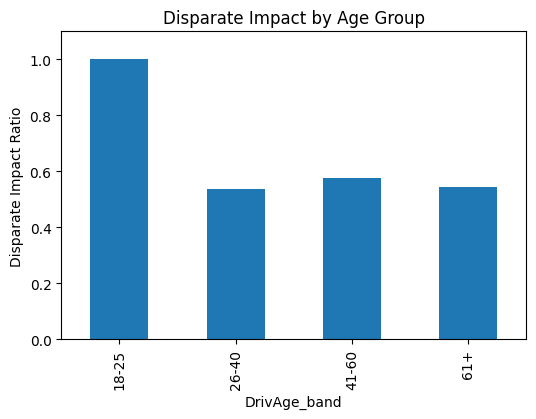

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
age_analysis["Disparate_Impact_Ratio"].plot(kind="bar")
plt.ylabel("Disparate Impact Ratio")
plt.title("Disparate Impact by Age Group")
plt.ylim(0, 1.1)

# SAVE FIGURE
plt.savefig("../figures/fairness_age_di.png", bbox_inches="tight", dpi=150)

plt.show()
